# SPICY Tutorial 1

In this tutorial we use SPICY to solve the Laplace equation on a rectangular domain. 

We start by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  
from spicy_class_m import spicy 

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

We consider a rectangular domain $(x,y) = [0,1]\times[0,1]$ and we sample $n_p=400$ points randomly in this domain.
The problem set and the boundary conditions are the following

$$
\Delta u = 0\\ 
u(x=0,y) = -y^2 \\
u(x,y=0) = x^2 \\
u(x=1,y) = 1-y^2 \\
u(x,y=1) = x^2-1
$$

The solution to this problem is $u=x^2-y^2$. We will use this to check the accuracy of the solver. Moreover, it is worth noticing that the solver will interpret the boundary conditions as constraints: these need not be on the investigated domain's boundaries. You could change the domain boundaries while still keeping the exact location of the constraints, and the results will be the same!

In [2]:
# Fix the random seed to ensure reproducibility
np.random.seed(42)

# Number of particles
n_p = 400

# Define the domain boundaries
x1, x2 = 0, 1
y1, y2 = 0, 1 

# Generate the random points (note: we write the code for sampling on an arbitrary rectangular domain)
X = np.random.random(n_p)*(x2 - x1) + x1
Y = np.random.random(n_p)*(y2 - y1) + y1

# The analytical solution for this is the following
U=X**2-Y**2


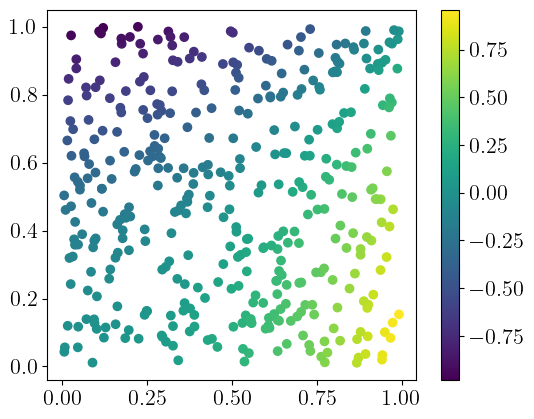

In [3]:
# Here we plot the solution on the sampled point (we will use it only to verify SPICY's accuracy)
P=plt.scatter(X,Y,c=U); plt.gca().set_aspect('equal'); plt.colorbar(P)


#### Step 1: Initialize the SPICY class
SPICY offers a RBF constrained regressor and a solver for Poisson's equation. To use the solver, we do not need any target data. Instead, we need to provide the source term on the RHS of the Poisson's equation. Since we are interested in the Laplace equation, this will be just a vector of zeros.

We thus initialize a SPICY object providing a vector of zero as target and we pick our basis to be either 'C4' or 'gauss'

In [4]:
SP = spicy([np.zeros(X.shape)], [X,Y], basis='c4')

#### Step 2: Peform the clustering
We then proceed with the clustering algorithm to collocate the RBFs. 

We use two levels for the $n_K$ vector, picking $n_K=[6,50]$ and we set $\epsilon_l=0.88$, with RBF's radious limited in $r_{mM}=[0.01,0.7]$. 

This means that SPICY will generate two levels of clustering with round(n_p/6) and round(n_p/50) clusters. The cluster barycenters will be the collocation point of the RBFs. Their shape factor will be computed so that the value of each RBF is equal to 0.88 at the closest barycenter. However, all radii r<0.01 or r>0.7 will be capped at 0.01 and 0.7, respectively.

Note that the definition of radious is linked to the shape factor of the RBF depending on whether we are using Gaussians or C4 bases.

This information is given to SPICY in one line:

In [5]:
SP.clustering([6,50], r_mM=[0.01,0.7], eps_l=0.88)

Clustering level 0 completed
Clustering level 1 completed


#### Step 3: Define the boundary conditions (constraints)

We define the boundary conditions as constraints. We use 10 collocation points on each segment interested, placed on a regular grid. Then we concatenate all of these into a single array and provide them to RBF with the option extra_RBF='True'. This means that additional RBFs will be placed on these points.

In [6]:
# Number of points for the vertical and horizontal boundary
n_c_V = n_c_H = 10

# Left boundary (x=x1, y=line)
X_Dir1 = np.ones(n_c_V)*(x1)
Y_Dir1 = np.linspace(y1,y2,n_c_V)
U_Dir1 = -Y_Dir1**2
# Bottom boundary (x=line, y=y1)
X_Dir2 = np.linspace(x1,x2,n_c_H)
Y_Dir2 = np.ones(n_c_H)*y1
U_Dir2 = X_Dir2**2
# Right boundary (x=x2, y=line)
X_Dir3 = np.ones(n_c_V)*x2
Y_Dir3 = np.linspace(y1,y2,n_c_V)
U_Dir3 = 1-Y_Dir3**2
# Top  boundary
X_Dir4 = np.linspace(x1,x2,n_c_H)
Y_Dir4 = np.ones(n_c_H)*y2
U_Dir4 = X_Dir4**2-1

# Assemble the constraints
X_Dir = np.concatenate((X_Dir1, X_Dir2, X_Dir3, X_Dir4))
Y_Dir = np.concatenate((Y_Dir1, Y_Dir2, Y_Dir3, Y_Dir4))
U_Dir = np.concatenate((U_Dir1, U_Dir2, U_Dir3, U_Dir4))
DIR = [X_Dir, Y_Dir, U_Dir]

# We set the constraints in these points and also place additional RBFs in each of these points
SP.scalar_constraints(DIR=DIR, extra_RBF=True)

40 Dirichlet conditions assigned
0 Neumann conditions assigned


SPICY has a plotting function, which is particularly useful in 2D. 

It produces two plots: the one on the left-hand side shows the RBFs in 2D together with the sampling points (in blue) and points where constraints are introduced (in red). One should make sure, using this plot, that the RBFs cover well the whole domain. The figure on the right shows the distribution of diameters. The two levels of clustering are evident, and one can see whether the capping enters into action. 


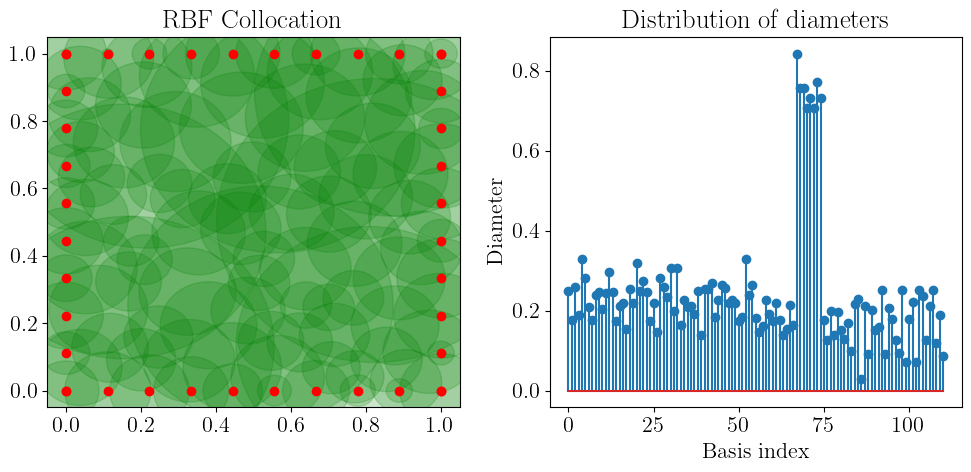

In [7]:
SP.plot_RBFs()

#### Step 4: Assemble the linear system
We can now assembly the linear system for the meshless Poisson solver. We will use no additional harmonic bases (these are currently under development). 

In [8]:
SP.Assembly_Poisson()

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [9]:
SP.Solve(K_cond=1e8)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [10]:
U_calc = SP.Get_Sol([X,Y])

We can now compute the error in the magnitude of $u$, which should be well below 1%.

In [11]:
error = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
print('l2 relative error in  phi: {0:.3f}%'.format(error*100))

l2 relative error in  phi: 0.047%


Plot the errors.

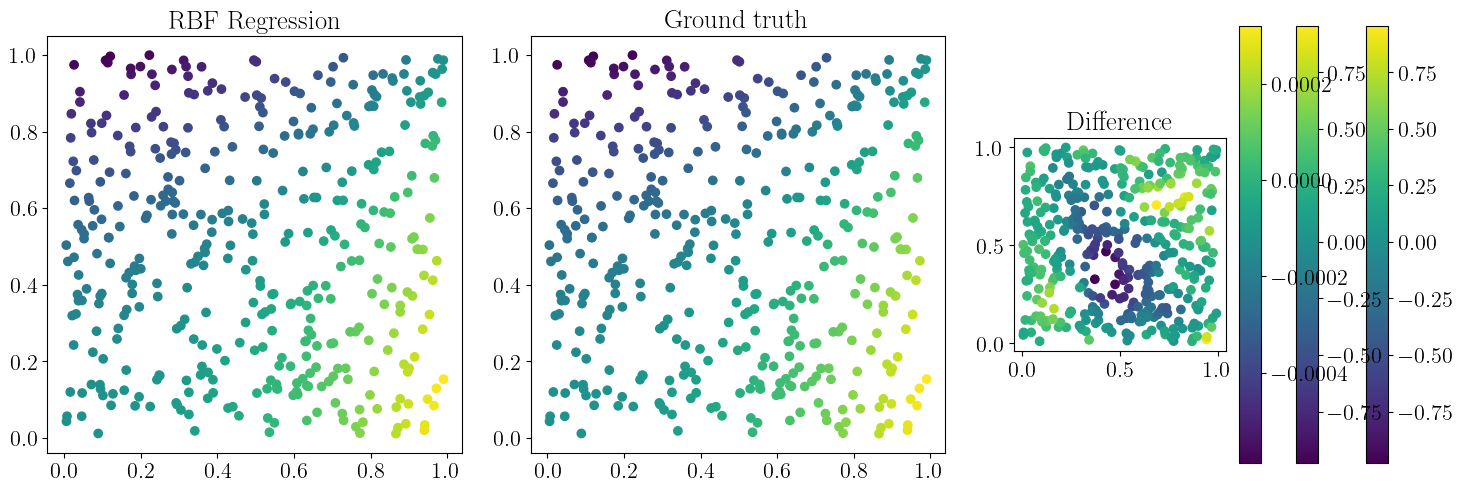

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5), dpi=100)
axes[0].set_title('RBF Regression')
sc=axes[0].scatter(X, Y, c=U_calc); plt.colorbar(sc)
axes[1].set_title('Ground truth')
sc2=axes[1].scatter(X, Y, c=U); plt.colorbar(sc2)
axes[2].set_title('Difference')
sc3=axes[2].scatter(X, Y, c=U_calc-U); plt.colorbar(sc3)

for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()


#### Compute Gradients

The main advantage of the proposed approach is that the RBF expansion allows for analytically computing derivatives.

If we interpret the previous solution as being a potential function, and we not call it $$\phi=x^2-y^2$$ then we can define a vector field such that $\nabla \phi= \mathbf{u}$. The vector field is thus $\mathbf{u}=(2x,-2y)$. Let's see the accuracy of the derivatives obtained via SPICY: 


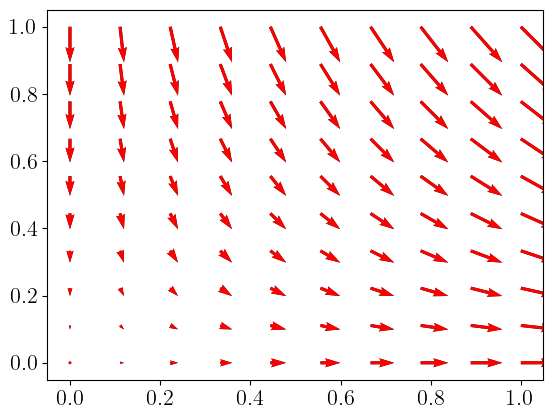

In [13]:
# We first define a new set of points. For the sake of demonstration we take a unfiform grid.
Xg, Yg = np.meshgrid(np.linspace(x1,x2,10), 
                     np.linspace(y1,y2,10))

# The gradient field u=dphidx and v=dphidy should be:
u_T=2*Xg
v_T=-2*Yg

# Using the function Get_first_Derivatives in the scipy object we can assign the output gradient to a field:
u_C,v_C=SP.Get_first_Derivatives([Xg.reshape(-1),
                                  Yg.reshape(-1)])    
# Note that the input grid should be a list

# We can now plot a quiver of the theoretical field in black and the computed one in red.

plt.quiver(Xg,Yg,u_T,v_T)
plt.quiver(Xg.reshape(-1),Yg.reshape(-1),
           u_C,v_C,color='red')


Yes, the red and the black fields are indistinguishable! 